In [11]:
import cv2
from libs.util import MaskGenerator
from copy import deepcopy
from matplotlib import pyplot as plt

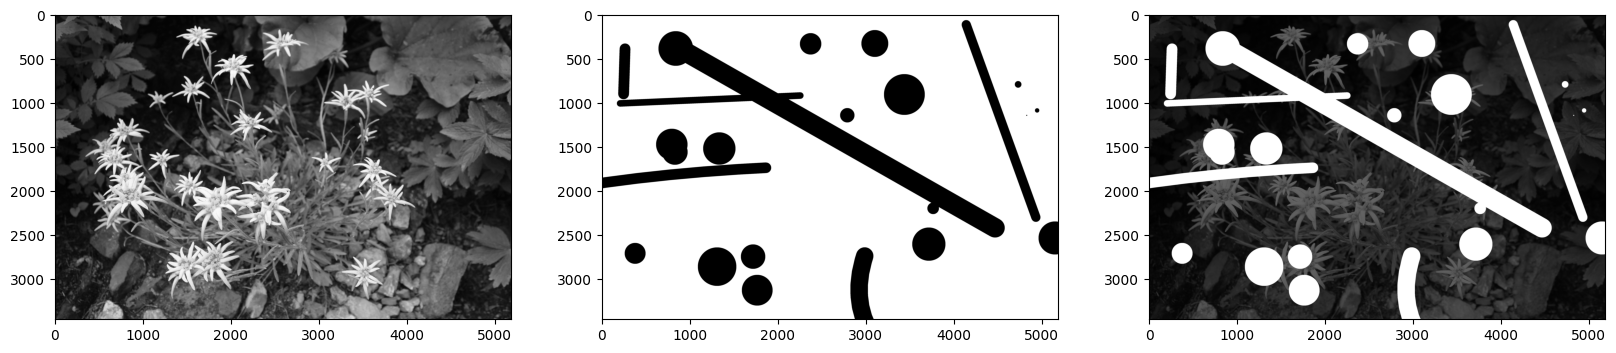

In [26]:
# Load grayscale image -> img.shape  == (H, W)
img = cv2.imread('image_generation/generated/backgrounds/i1.png',
                 cv2.IMREAD_GRAYSCALE)

# Ask the mask generator for ONE channel
mask_generator = MaskGenerator(img.shape[0], img.shape[1], 1, rand_seed=42)
mask = mask_generator.sample()          # shape (H, W) or (H, W, 1)

# If it came back as (H, W, 1) squeeze the extra axis
mask = mask.squeeze()                   # now (H, W)

masked_img = img.copy()
masked_img[mask == 0] = 255

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img, cmap='gray')
axes[1].imshow(mask*255, cmap='gray')
axes[2].imshow(masked_img, cmap='gray')
plt.show()

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from libs.pconv_layer import PConv2D      # ← your patched file

# ----------------------------------------------------------------------
# Assume you already loaded a grayscale image with cv2.IMREAD_GRAYSCALE
# so `img.shape` is (H, W).  We make the shapes explicit to avoid
# shape[2] IndexError.
# ----------------------------------------------------------------------
H, W = img.shape               # img is a 2-D array
C_img  = 1                     # grayscale image
C_mask = 1                     # binary mask

# ----------------------- Inputs ---------------------------------------
input_img  = Input(shape=(H, W, C_img),  name='input_img')
input_mask = Input(shape=(H, W, C_mask), name='input_mask')

# ----------------------- Encoder-only toy stack -----------------------
x, m1 = PConv2D( 8, (7, 7), strides=(2, 2))([input_img,  input_mask])
x, m2 = PConv2D(16, (5, 5), strides=(2, 2))([x,          m1])
x, m3 = PConv2D(32, (5, 5), strides=(2, 2))([x,          m2])
x, m4 = PConv2D(64, (3, 3), strides=(2, 2))([x,          m3])
x, m5 = PConv2D(64, (3, 3), strides=(2, 2))([x,          m4])
x, m6 = PConv2D(64, (3, 3), strides=(2, 2))([x,          m5])
x, m7 = PConv2D(64, (3, 3), strides=(2, 2))([x,          m6])
x, m8 = PConv2D(64, (3, 3), strides=(2, 2))([x,          m7])

# ----------------------------------------------------------------------
# Build and compile.
# NOTE: Categorical-crossentropy makes sense only for multi-class
# classification; an in-painting stack usually trains with L1, L2 or
# perceptual losses on the final image *only*.  Here I keep your multi-
# output setup but switch to MAE so the model can run without crashing.
# ----------------------------------------------------------------------
model = Model(
    inputs=[input_img, input_mask],
    outputs=[x, m1, m2, m3, m4, m5, m6, m7, m8],
)

model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary(line_length=120)


AttributeError: can't set attribute 'kernel'

In [38]:
from libs.pconv_layer import PConv2D
from tensorflow.keras.layers import Input

# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

IndexError: tuple index out of range